# MultiGroupRCD

## Import and settings

In [1]:
import random
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Test data
We generate two datasets consisting of 6 variables and 1 latent variable.

In [2]:
def get_coef():
    coef = random.random()
    return coef if coef >= 0.5 else coef - 1.0
get_external_effect = lambda n: np.random.normal(0.0, 0.5, n) ** 3

In [3]:
B1 = np.array([[       0.0,        0.0,        0.0,        0.0,        0.0, get_coef(),        0.0],
               [       0.0,        0.0,        0.0,        0.0,        0.0, get_coef(),        0.0],
               [get_coef(), get_coef(),        0.0,        0.0,        0.0,        0.0,        0.0],
               [       0.0,        0.0, get_coef(),        0.0,        0.0,        0.0, get_coef()],
               [       0.0,        0.0, get_coef(),        0.0,        0.0,        0.0, get_coef()],
               [       0.0,        0.0,        0.0,        0.0,        0.0,        0.0,        0.0],
               [       0.0,        0.0,        0.0,        0.0,        0.0,        0.0,        0.0]])

samples = 1000
x5 = get_external_effect(samples)
x6 = get_external_effect(samples)
x0 = x5 * B1[0, 5] + get_external_effect(samples)
x1 = x5 * B1[1, 5] + get_external_effect(samples)
x2 = x0 * B1[2, 0] + x1 * B1[2, 1] + get_external_effect(samples)
x3 = x2 * B1[3, 2] + x6 * B1[3, 6] + get_external_effect(samples)
x4 = x2 * B1[4, 2] + x6 * B1[4, 6] + get_external_effect(samples)

# x5, x6 is a latent variable.
X1 = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

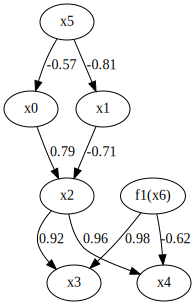

In [4]:
make_dot(B1, labels=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'f1(x6)'])

In [5]:
B2 = np.array([[       0.0,        0.0,        0.0,        0.0,        0.0, get_coef(),        0.0],
               [       0.0,        0.0,        0.0,        0.0,        0.0, get_coef(),        0.0],
               [get_coef(), get_coef(),        0.0,        0.0,        0.0,        0.0,        0.0],
               [       0.0,        0.0, get_coef(),        0.0,        0.0,        0.0, get_coef()],
               [       0.0,        0.0, get_coef(),        0.0,        0.0,        0.0, get_coef()],
               [       0.0,        0.0,        0.0,        0.0,        0.0,        0.0,        0.0],
               [       0.0,        0.0,        0.0,        0.0,        0.0,        0.0,        0.0]])

samples = 1000
x5 = get_external_effect(samples)
x6 = get_external_effect(samples)
x0 = x5 * B2[0, 5] + get_external_effect(samples)
x1 = x5 * B2[1, 5] + get_external_effect(samples)
x2 = x0 * B2[2, 0] + x1 * B2[2, 1] + get_external_effect(samples)
x3 = x2 * B2[3, 2] + x6 * B2[3, 6] + get_external_effect(samples)
x4 = x2 * B2[4, 2] + x6 * B2[4, 6] + get_external_effect(samples)

# x5, x6 is a latent variable.
X2 = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

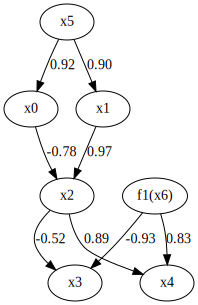

In [6]:
make_dot(B2, labels=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'f1(x6)'])

We create a list variable that contains two datasets.

In [7]:
X_list = [X1, X2]

## Causal Discovery
To run causal discovery for multiple datasets, we create a `MultiGroupRCD` object and call the `fit()` method.

In [8]:
model = lingam.MultiGroupRCD()
model.fit(X_list)

Using the `ancestors_list_` properties, we can see the list of ancestors sets as a result of the causal discovery.

In [9]:
ancestors_list = model.ancestors_list_

for i, ancestors in enumerate(ancestors_list):
    print(f'M{i}={ancestors}')

M0={5}
M1={0, 5}
M2={0, 1, 5}
M3={0, 1, 2}
M4={0, 1, 2}
M5=set()


Also, using the `adjacency_matrix_` properties, we can see the adjacency matrix as a result of the causal discovery. The coefficients between variables with latent confounders are np.nan.

[[ 0.     0.     0.     0.     0.    -0.606]
 [ 0.     0.     0.     0.     0.    -0.785]
 [ 0.801 -0.755  0.     0.     0.     0.   ]
 [ 0.     0.     0.895  0.       nan  0.   ]
 [ 0.     0.     0.977    nan  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]]


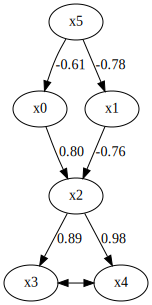

In [10]:
print(model.adjacency_matrices_[0])
make_dot(model.adjacency_matrices_[0])

[[ 0.     0.     0.     0.     0.     0.958]
 [ 0.     0.     0.     0.     0.     0.914]
 [-0.799  0.989  0.     0.     0.     0.   ]
 [ 0.     0.    -0.534  0.       nan  0.   ]
 [ 0.     0.     0.908    nan  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]]


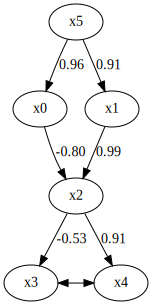

In [11]:
print(model.adjacency_matrices_[1])
make_dot(model.adjacency_matrices_[1])

To compare, we run `MultiGroupRCD` with single dataset concatenating two datasets. You can see that the causal structure cannot be estimated correctly for a single dataset.

(2000, 6)
M0={5}
M1={0, 5}
M2={0, 1, 5}
M3={0, 1, 2}
M4={0, 1, 2}
M5=set()


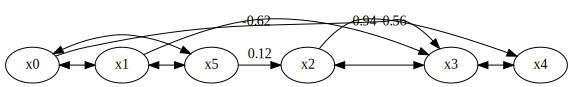

In [12]:
X_all = pd.concat([X1, X2])
print(X_all.shape)

model_all = lingam.RCD()
model_all.fit(X_all)

ancestors_list = model.ancestors_list_

for i, ancestors in enumerate(ancestors_list):
    print(f'M{i}={ancestors}')
    
make_dot(model_all.adjacency_matrix_)